### Data exploration

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima , ARIMA , model_selection
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

In [2]:
train = pd.read_csv('/Users/aryan/Coding/Projects/archive (11)/train.csv')
features = pd.read_csv('/Users/aryan/Coding/Projects/archive (11)/features.csv')
df = pd.merge(train,features,on='Store')

In [3]:
df1 = df[['Date_x','Weekly_Sales']].copy()
df1.columns = ['Date','Weekly_Sales']
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index(df1['Date'],inplace=True)
df1.drop('Date',axis=1,inplace=True)
monthly_df = df1.resample('W').mean()

In [4]:
# Spliting the data into train and test
train = monthly_df[:round(len(monthly_df)*.8)]
test = monthly_df[round(len(monthly_df)*.8):]

<Axes: xlabel='Date'>

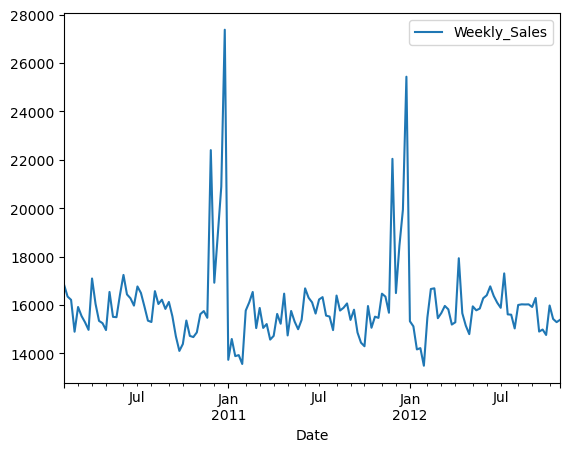

In [6]:
monthly_df.plot()

In [7]:
sd = seasonal_decompose(monthly_df,model = 'multiplicative')

In [8]:
sda = seasonal_decompose(monthly_df,model = 'additive')

<Axes: xlabel='Date'>

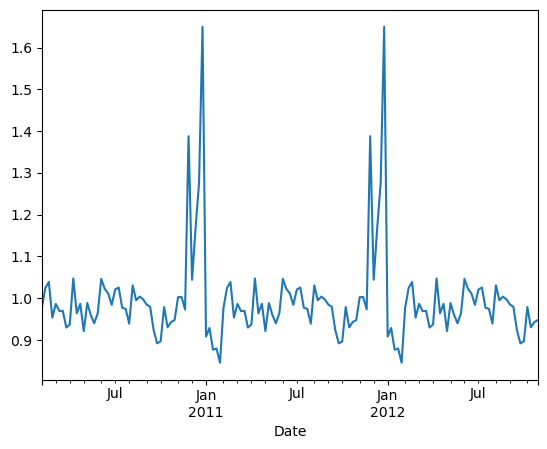

In [9]:
sd.seasonal.plot()


<Axes: xlabel='Date'>

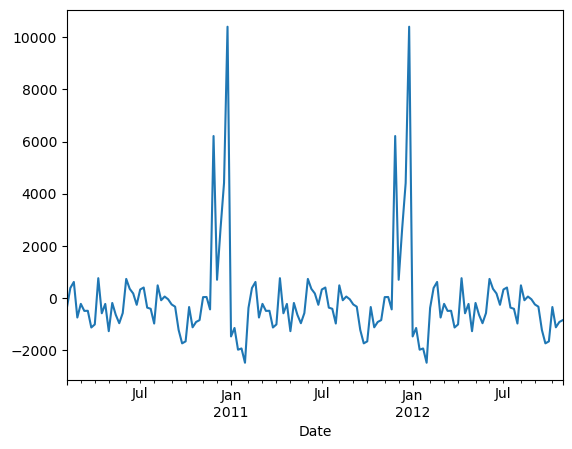

In [10]:
sda.seasonal.plot()

<Axes: xlabel='Date'>

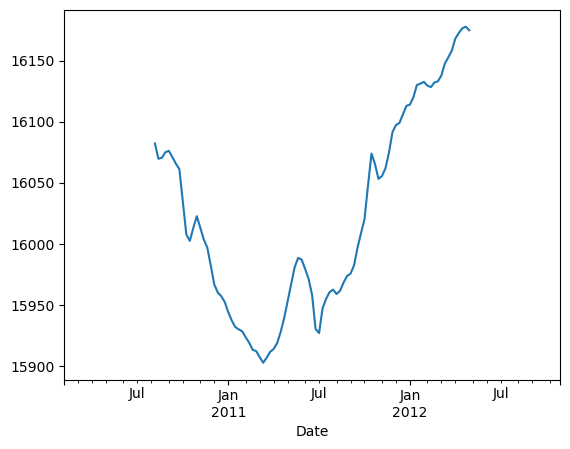

In [11]:
sd.trend.plot()

<Axes: xlabel='Date'>

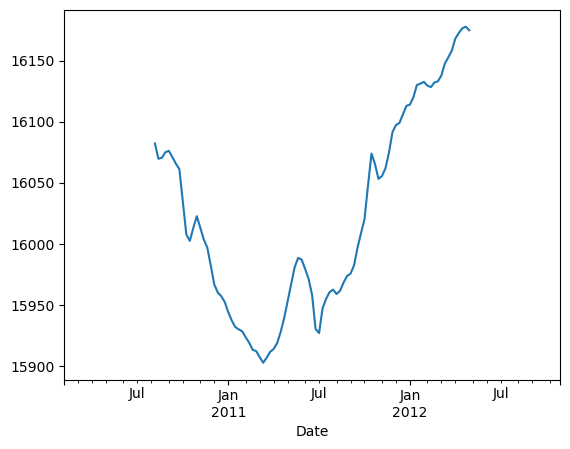

In [12]:
sda.trend.plot()

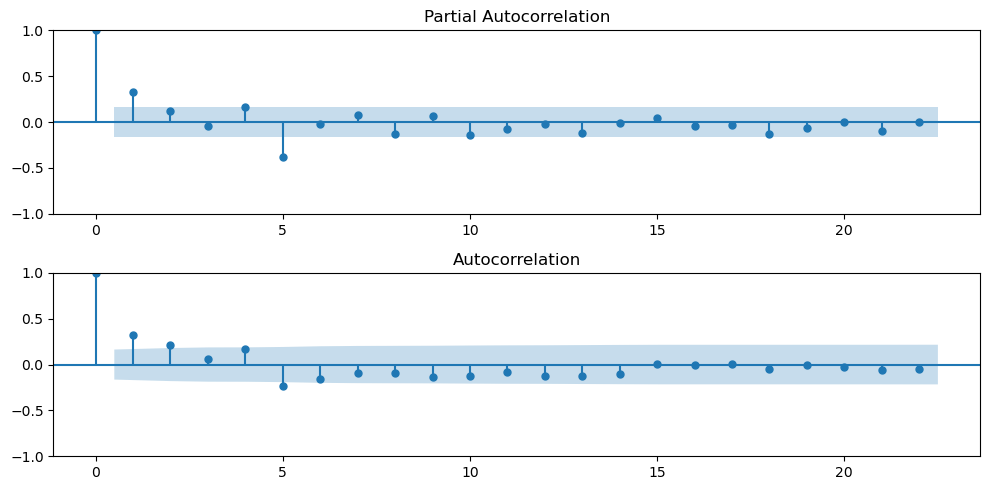

In [13]:
fig , axs = plt.subplots(2,1,figsize=(10,5))
plot_pacf(monthly_df,ax = axs[0])
plot_acf(monthly_df,ax=axs[1])
plt.tight_layout()
plt.show()

### Checking for random walk

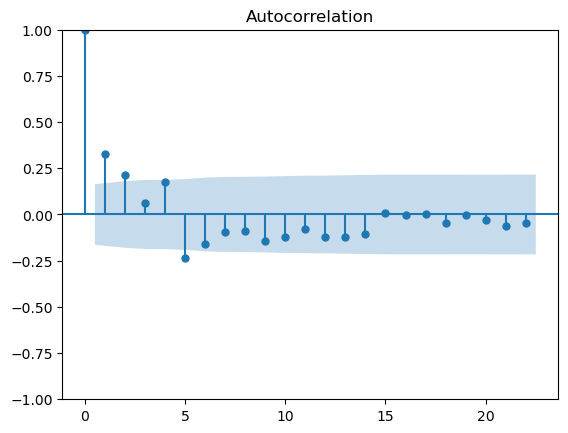

In [14]:
plot_acf(monthly_df)
plt.show()

In [15]:
adfuller(monthly_df)


(-5.930802744748704,
 2.3832272706103354e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.7748547116485)

-data is stationary

### Check for white noise

In [16]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(monthly_df, order=(1,0,0))
model_fit = model.fit()

In [17]:
residulas = model_fit.resid

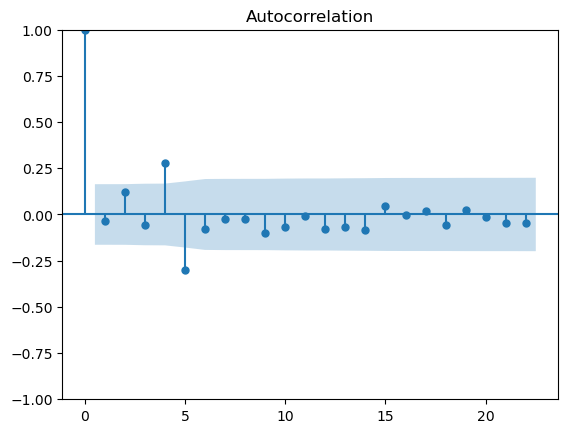

In [18]:
plot_acf(residulas)
plt.show()

In [19]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(residulas, lags=[10], return_df=True)  # Test up to lag 10
print(lb_test)


      lb_stat  lb_pvalue
10  31.026051   0.000581


-not white noise as the test suggests

### ARIMA

In [20]:
model = auto_arima(train['Weekly_Sales'],seasonal=False,stepwise=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -1025.242
Date:                Tue, 08 Oct 2024   AIC                           2062.483
Time:                        14:51:55   BIC                           2078.900
Sample:                    02-07-2010   HQIC                          2069.146
                         - 04-08-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0641      0.194      0.330      0.741      -0.316       0.445
ar.L2          0.4038      0.126      3.215      0.001       0.158       0.650
ar.L3          0.1280      0.083      1.536      0.1

In [21]:
# Ensure you are importing the correct ARIMA class
from statsmodels.tsa.arima.model import ARIMA
# Now, instantiate the ARIMA model
modela = ARIMA(train['Weekly_Sales'], order=(1, 0, 1))
modela_res=modela.fit()
print(modela_res.summary())

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1019.426
Date:                Tue, 08 Oct 2024   AIC                           2046.853
Time:                        14:51:55   BIC                           2057.798
Sample:                    02-07-2010   HQIC                          2051.295
                         - 04-08-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.603e+04    545.758     29.365      0.000     1.5e+04    1.71e+04
ar.L1          0.5642      0.264      2.137      0.033       0.047       1.082
ma.L1         -0.2675      0.313     -0.854      0.3

#### Prediction

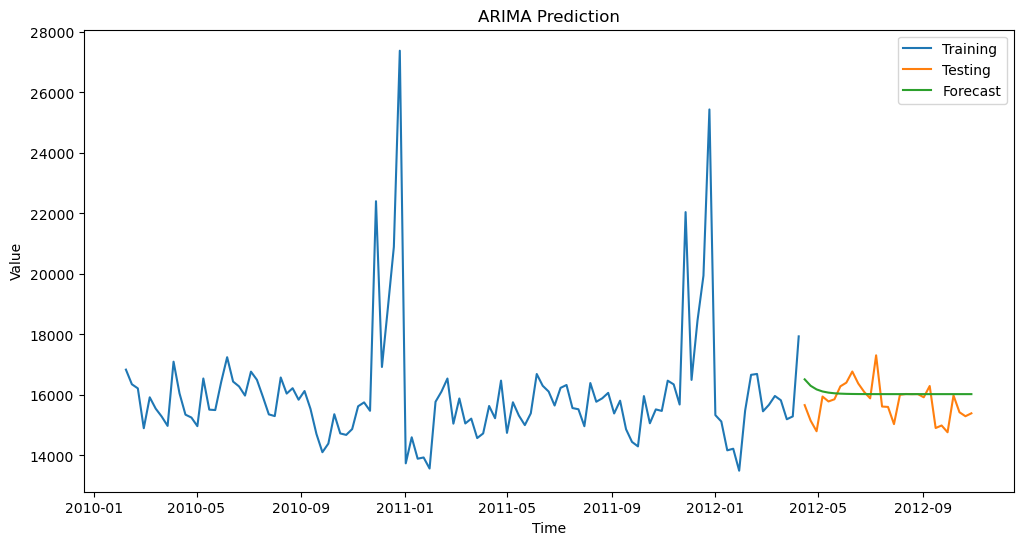

In [22]:
prediction_arima= modela_res.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.plot(prediction_arima, label='Forecast')
plt.legend()
plt.title('ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

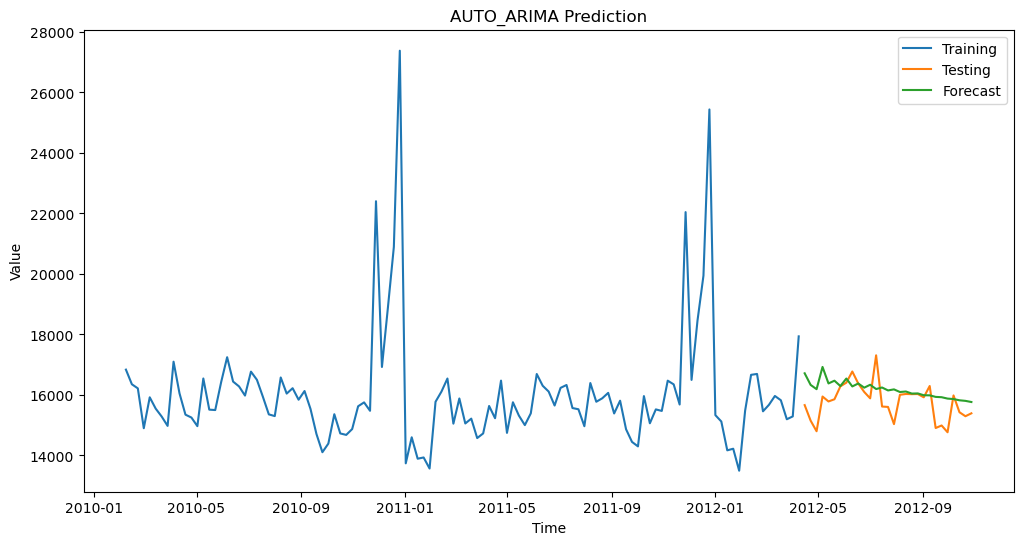

In [23]:
prediction_auto = model.predict(n_periods=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.plot(prediction_auto, label='Forecast')
plt.legend()
plt.title('AUTO_ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [24]:
print(mean_absolute_percentage_error(test,prediction_arima)*100)
print(mean_absolute_percentage_error(test,prediction_auto)*100)

3.311021136014531
3.455708742872268


### SARIMA

In [25]:
model_sarima = auto_arima(train['Weekly_Sales'],m=52,stepwise=True)
print(model_sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  114
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood                -995.187
Date:                             Tue, 08 Oct 2024   AIC                           2004.373
Time:                                     14:53:39   BIC                           2023.526
Sample:                                 02-07-2010   HQIC                          2012.146
                                      - 04-08-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.075e+04   7313.487      1.470      0.141   -3581.564    2.51e+04
ar.L1         -0.7519      

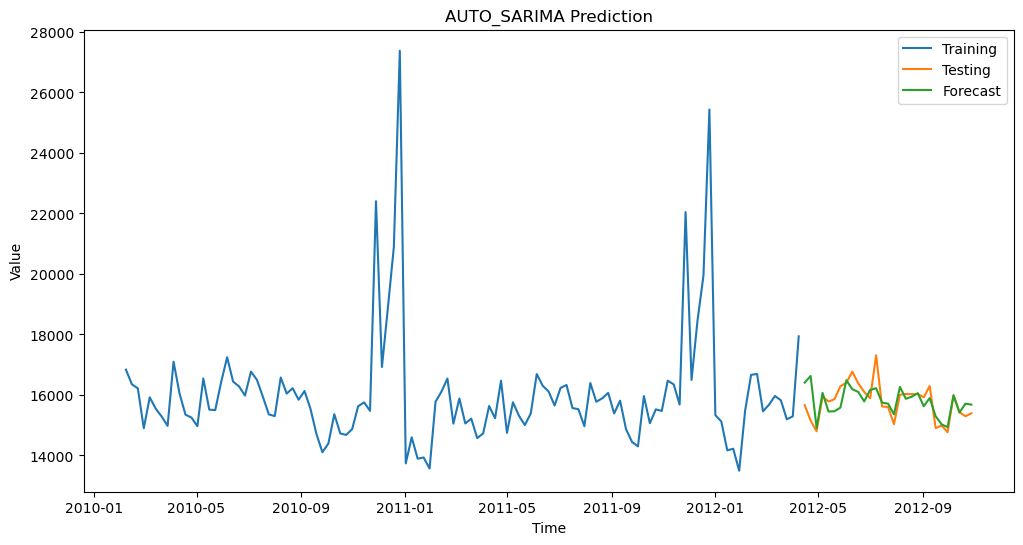

In [26]:
prediction_sarima = model_sarima.predict(n_periods=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.plot(prediction_sarima, label='Forecast')
plt.legend()
plt.title('AUTO_SARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [27]:
print(mean_absolute_percentage_error(test,prediction_sarima)*100)


2.087372293827152


In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
mean_squared_error(test,prediction_sarima)

214726.40610233013

### SARIMAX

In [16]:
df2 = df[['Date_x','Weekly_Sales','Temperature','Fuel_Price']].copy()
df2.columns = ['Date','Weekly_Sales','Temperature','Fuel_Price']
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index(df2['Date'],inplace=True)
df2.drop('Date',axis=1,inplace=True)
monthly_df_exo = df2.resample('W').mean()

In [17]:
# Spliting the data into train and test
train = monthly_df_exo.iloc[:round(len(monthly_df_exo)*.8),:3]
test = monthly_df_exo.iloc[round(len(monthly_df_exo)*.8):,:3]

In [18]:
# Spliting the data into train and test
exo_train = monthly_df_exo.iloc[:round(len(monthly_df_exo)*.8),-1:]
exo_test = monthly_df_exo.iloc[round(len(monthly_df_exo)*.8):,-1:]

In [33]:
model_sarimax = auto_arima(train['Weekly_Sales'],m=52,X=exo_train)
print(model_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  114
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 52)   Log Likelihood                -956.818
Date:                             Tue, 08 Oct 2024   AIC                           1925.636
Time:                                     15:00:03   BIC                           1942.053
Sample:                                 02-07-2010   HQIC                          1932.299
                                      - 04-08-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fuel_Price  4731.8628    146.908     32.210      0.000    4443.929    5019.797
ar.L1         -0.7866      

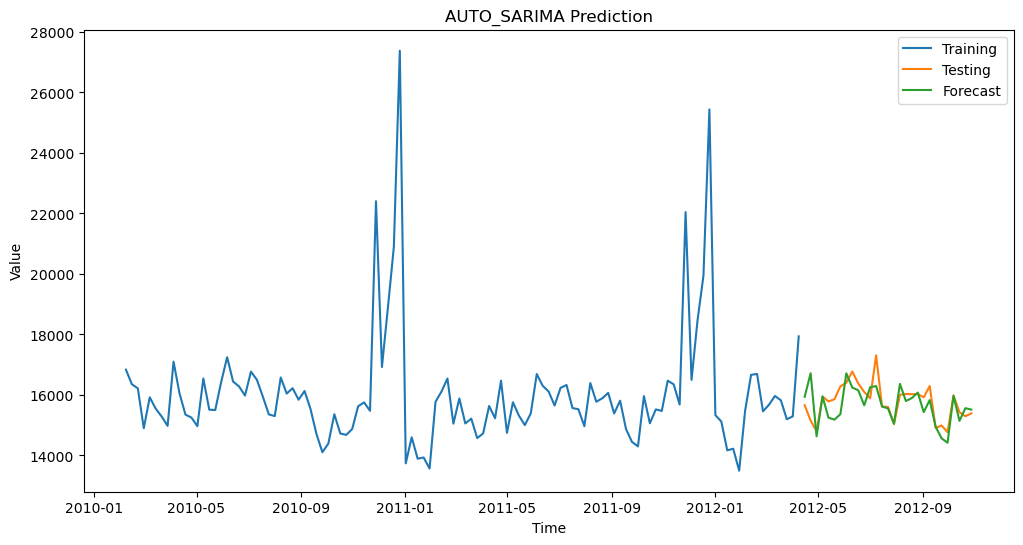

In [34]:
prediction_sarimax = model_sarimax.predict(n_periods=len(test),X=exo_test)
plt.figure(figsize=(12, 6))
plt.plot(train['Weekly_Sales'], label='Training')
plt.plot(test['Weekly_Sales'], label='Testing')
plt.plot(prediction_sarimax, label='Forecast')
plt.legend()
plt.title('AUTO_SARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [35]:
print(mean_absolute_percentage_error(test['Weekly_Sales'],prediction_sarimax)*100)

2.240051841432515


In [36]:
test

,Weekly_Sales,Temperature,Fuel_Price
Date,,,
2012-04-15,15663.171451,58.849605,3.407518
2012-04-22,15150.430178,58.836623,3.407135
2012-04-29,14799.187167,58.849628,3.407659
2012-05-06,15947.275103,58.789988,3.407210
2012-05-13,15784.015806,58.824056,3.407937
2012-05-20,15856.396620,58.800503,3.407926
2012-05-27,16284.414590,58.828379,3.407782
2012-06-03,16405.589439,58.786944,3.407160
2012-06-10,16774.044520,58.807949,3.407841


### Cross validation

In [46]:
# Model for cv
from pmdarima import ARIMA
model_cv = ARIMA(order = (1,0,2), seasonal_order= (1,0,0,52) )


In [54]:
# set cv rules
cv = model_selection.RollingForecastCV(h = 4,step = 1,initial=52)

In [55]:
cv_score = model_selection.cross_val_score(model_cv,y = train['Weekly_Sales'],X = exo_train,scoring='mean_squared_error',cv=cv,verbose=1,error_score="raise")

In [57]:
# Cv performance
rmse = np.sqrt(np.average(cv_score))

703.0071104389222

In [69]:
exo_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2010-02-07 to 2012-04-08
Freq: W-SUN
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fuel_Price  114 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


### Parameter Tunning

In [73]:
# Defining the parameters
# param_grid = {'p':[1,4,5],'d':[0],'q': [1,2,4,5],'P':[1,2],'D':[0],'Q':[0,1,2]}
param_grid = {'p':[1,4],'d':[0],'q': [1,2],'P':[1,2],'D':[0],'Q':[0,1]}
grid = ParameterGrid(param_grid)
len(list(grid))

16

In [75]:
# Defining the parameters
param_grid = {'p':[1,4,5],'d':[0],'q': [1,2,4,5],'P':[1,2],'D':[0],'Q':[0]}
grid = ParameterGrid(param_grid)
# Parameter tunning looop
rmse_list = []
from pmdarima import ARIMA
cv = model_selection.RollingForecastCV(h = 4,step = 1,initial=52)
for params in grid:
    # Build model with a set of param
    model_cv = ARIMA(order = (params['p'],params['d'],params['q']),
                    seasonal_order= (params['P'],params['D'],params['Q'],52) 
                    )

    # Evaluate the model
    cv_score = model_selection.cross_val_score(model_cv,y = train['Weekly_Sales'],
                                                X = exo_train,
                                                scoring='mean_squared_error',
                                                cv=cv,
                                                verbose=1,
                                                error_score="raise"
                                                )

    # Store the error
    rmse = np.sqrt(np.average(cv_score))
    rmse_list.append(rmse)

KeyboardInterrupt: 